In [13]:
import pandas as pd
import yaml
import torch
import os
from pytorch_lightning import Trainer, seed_everything
from eyemind.trainer.loops import KFoldLoop
import eyemind
from eyemind.models.transformers import InformerEncoderDecoderModel, InformerEncoderFixationModel, InformerMultiTaskEncoderDecoder
from eyemind.dataloading.informer_data import InformerDataModule, InformerMultiLabelDatamodule,  InformerVariableLengthDataModule
import matplotlib.pyplot as plt
from eyemind.analysis.visualize import plot_scanpath_labels, viz_coding, fixation_image, plot_scanpath_pc

# Overview
Simply load in already-trained models and generate predictions

This shouldn't be this difficult!

# Notes


in the original informer code, there is a command line option
`parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')`
Check what this does

## encoder only
I have managed to get logits from the encoder, but model(batch) does not work when mdoel is the entire multitask enc-decoder stack.

## fixation decoder
How to load this? 
A: model.fi_decoder

# TODO ideas
[x] try loading encoder and fi decoder separately

[x] get predictions for other tasks

[x] plot predictions

[ ] plot attention




In [14]:
# Load our trained encoder decoder from checkpoint for each fold
# this shouold load the encoder and its 4 decoders

# using pytorch lightning module
# https://lightning.ai/docs/pytorch/stable/deploy/production_basic.html

repodir = os.path.dirname(os.path.dirname(eyemind.__file__))
test_data_dir = os.path.join(repodir,"data/EML/gaze+fix+reg")
test_label_file =  os.path.join(repodir,"./data/EML/EML1_pageLevel_500+_matchEDMinstances.csv")
save_dir_base = f"{repodir}/lightning_logs/2024/cluster/new_multitask_informer_pretraining"
is_old_version=False
fold=0
save_dir = os.path.join(save_dir_base, f'fold{fold}/')
config_path=os.path.join(save_dir,"config.yaml")
ckpt_path = os.path.join(save_dir,"checkpoints","last.ckpt")
# ckpt_path = os.path.join(save_dir,"checkpoints","epoch=168-step=8619.ckpt")


with open(config_path, "r") as f:
    config = yaml.safe_load(f)
seed_everything(config["seed_everything"], workers=True) # not sure if this is needed

model = InformerMultiTaskEncoderDecoder.load_from_checkpoint(ckpt_path,
                                                # encoder_weights_path=None
                                                )
encoder=model.encoder
# decoder=model.fi_decoder
model.eval()
encoder.eval()
# decoder.eval()

# set up an InformerDataModule to load the same data as used in training
# trainer = Trainer(**config["trainer"])
# data_dir = os.path.join(repodir,config["data"]["data_dir"])
# label_file = os.path.join(repodir,config["data"]["label_filepath"])
config["data"]["data_dir"]=test_data_dir
config["data"]["label_filepath"]=test_label_file

# edit config for consistency woth the new version of the datamodule
if is_old_version:
    config["data"]["min_sequence_length"] = config["data"]["min_scanpath_length"]
    config["data"].pop("min_scanpath_length")
    config["data"]["sample_label_col"]="fixation_label"
    config["data"]["file_label_col"]=None



Global seed set to 303


In [15]:

datamodule = InformerMultiLabelDatamodule(**config["data"])
datamodule.setup()

test_dl = datamodule.get_dataloader(datamodule.test_dataset) # this is the held out fold's dataloader
for i,batch in enumerate(test_dl):
    print(f"batch: {i}")
    print(f"length of batch: {len(batch)}")
    with torch.no_grad():
        # preds = model(batch) # this step fails
        logits=encoder(batch[0], None)
        # fixation_logits = model.fi_decoder.forward(logits)
        # fixation_preds=fixation_logits.max(2).indices
        # fixation_targets = batch[1]

    if i==0: # just run a couple to check
        break


batch: 0
length of batch: 5


AttributeError: 'list' object has no attribute 'shape'

In [6]:
config["data"]

{'data_dir': '/home/rosy/DeepGaze/data/EML/gaze+fix+reg',
 'label_filepath': '/home/rosy/DeepGaze/./data/EML/EML1_pageLevel_500+_matchEDMinstances.csv',
 'sample_label_col': 'regression_label',
 'file_label_col': 'readWPM',
 'load_setup_path': None,
 'test_dir': None,
 'train_dataset': None,
 'val_dataset': None,
 'test_dataset': None,
 'train_fold': None,
 'val_fold': None,
 'sequence_length': 500,
 'num_workers': 16,
 'batch_size': 32,
 'pin_memory': True,
 'drop_last': True,
 'label_length': 48,
 'pred_length': None,
 'min_sequence_length': 500,
 'contrastive': True,
 'scale_file_label': True,
 'scale_sample_label': False,
 'scale_gaze': True,
 'mean_gaze_xy': [-0.698, -1.94],
 'std_gaze_xy': [4.15, 3.286],
 'mean_sample_label': 0.0,
 'std_sample_label': 1.0,
 'usecols': [1, 2]}

In [17]:
# Try running encoder on batch
# batch size is 32
# but batch contains 4 elements each of length 32

with torch.no_grad():
    print((len(batch)))
    if len(batch) == 4:
        X, yi, X2, CL_y = batch
    elif len(batch) == 5:
        X, yi,file_labels , X2, CL_y= batch
    print(batch[0].shape) # <- sequence
    print(batch[1].shape) # <- fixation targets, but we want to pretend we don't know these!
    print(batch[2].shape) # <- second sequence for contrastive
    print(batch[3].shape) # <- Some binary label per instance = contrastive label
    if len(batch)>4:
        print(batch[4].shape)
    with torch.no_grad():
        logits = encoder.forward(X, None)
    perc_nan = torch.isnan(logits).sum() / torch.numel(logits)
    print(f'percentage of nans in  encoder logits: {100*perc_nan}')
    # if torch.equal(logits2, logits):
    #     print('providing labels made no difference')
    # else:
    #     print('removing labels changed the predicitons')

    print(f'logits shape: {logits.shape}')


5
torch.Size([32, 500, 2])
torch.Size([32, 500])
torch.Size([32, 1])
torch.Size([32, 500, 2])
torch.Size([32])
percentage of nans in  encoder logits: 0.0
logits shape: torch.Size([32, 500, 512])


In [18]:
    print(logits[0,:,1])
logits

tensor([-0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097, -0.0097,
        -0.0097, -0.0097, -0.0097, -0.00

tensor([[[-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         ...,
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031]],

        [[-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         ...,
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         [-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031]],

        [[-0.0072, -0.0097, -0.0057,  ..., -0.0750, -0.0208, -0.0031],
         [-0.0072, -0.0097, -0.0057,  ..., -0

In [19]:
# # We can see the attributes of the full model using dir
# dir(model)
# # it has a module list of decoders
# dir(model.decoders)
if hasattr(model, "fi_decoder"):
    print("model has fi_decoder")
elif hasattr(model, "fm_decoder"):
    model.fi_decoder = model.fm_decoder
    print("model has fm_decoder")
else:
    print("model has no fixation decoder")
# Apart from pc we can access each task's decoder like so:
print(f'FI decoder: {model.fi_decoder}')
print(f'RC decoder: {model.rc_decoder}')
print(f'CL decoder: {model.cl_decoder}')

model has fm_decoder
FI decoder: Linear(in_features=512, out_features=3, bias=True)
RC decoder: InformerDecoder(
  (dec_embedding): GazeEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(2, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (self_attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (out_projection): Linear(in_features=512, out_features=512, bias=True)
        )
        (cross_attention): AttentionLayer(
    

In [20]:
# Great! Let's use the logits from the encoder as input to the fi decoder...

fixation_logits = model.fi_decoder.forward(logits)
# this is of shape n, len, 2. I assume the 2 dimensions here are prob(fix) and prob(sacc)? 
# do we need to just take one dimension? And softmax then threshold >/5?
fixation_preds=fixation_logits.max(2).indices
print(fixation_logits)
fixation_targets = batch[1]
# how many unique values are there in the targets?
print(f"unique preds: {torch.unique(fixation_preds)}")
print(f"unique targets: {torch.unique(fixation_targets)}")
# or reshape batch into one long vector in Ricks's code, to get batch-wisemetric:
logits_long = fixation_logits.squeeze().reshape(-1,2)
targets_long = fixation_targets.reshape(-1).long()


tensor([[[-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         ...,
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340]],

        [[-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         ...,
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340]],

        [[-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         ...,
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340]],

        ...,

        [[-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         ...,
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340],
         [-0.0435, -0.0375,  0.0340]],

        [[

torch.Size([500])
torch.Size([500])
sequence length: 500


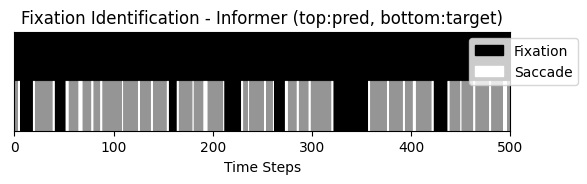

In [21]:

# pick one from batch to plot
ix=7
one_pred = fixation_preds[ix,:]
one_target = fixation_targets[ix,:]
print(one_pred.shape)
print(one_target.shape)
fixation_image(one_pred, one_target, "Fixation Identification - Informer (top:pred, bottom:target)")

# SUCCESS!!


In [22]:
# evaluate FI 

#mask = torch.any(X == -180, dim=1)
loss = model.fi_criterion(logits_long, targets_long)
preds = model._get_preds(logits)
probs = model._get_probs(logits)
fixation_targets = fixation_targets.int()
auprc = model.fi_metric(probs, fixation_targets)

AttributeError: 'InformerMultiTaskEncoderDecoder' object has no attribute 'fi_criterion'

In [23]:
# predictive coding one batch
from eyemind.dataloading.batch_loading import predictive_coding_batch

pred_length = 150
label_length = 100
pc_seq_length = 350
X_pc, Y_pc = predictive_coding_batch(X, pc_seq_length=pc_seq_length, label_length=label_length, pred_length=pred_length)
with torch.no_grad():
    pc_logits = model.pc_decoder.forward(logits, Y_pc, pred_length=pred_length).squeeze()
pc_target=Y_pc[:,:-pred_length] # take just the predicted part as target
# coutn how many nan in pc_logits
nan_count = torch.isnan(pc_logits).sum()
# print(f"Number of nan in pc_logits: {nan_count} / {pc_logits.numel()}")
print(f"PC logits: {pc_logits.shape}")
perc_nan = nan_count/pc_logits.numel()
print(f"Percentage of nan in PC logits: {100*perc_nan:.2f}")
pc_logits = model.scaler.inverse_transform(pc_logits)
# pc_target = model.scaler.inverse_transform(target)
# X = model.scaler.inverse_transform(X)

PC logits: torch.Size([32, 150, 2])
Percentage of nan in PC logits: 0.00


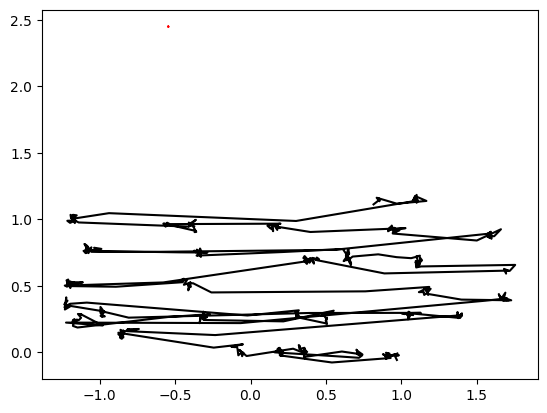

In [ ]:
ix=4

handle = plot_scanpath_pc(X[ix,:,0], X[ix,:,1], pc_logits[ix,:,0].cpu().detach().numpy(), pc_logits[ix,:,1].cpu().detach().numpy())


Percentage of nan in recon_logits: 6.25


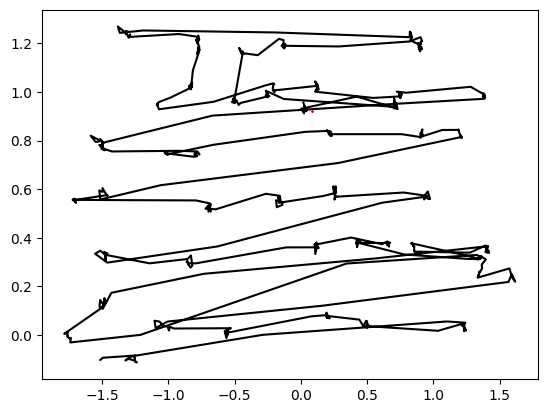

In [ ]:
# reconstruction
with torch.no_grad():
    recon_logits = model.rc_decoder.forward(logits, X)
recon_targets = X

perc_nan = torch.isnan(recon_logits).sum()/recon_logits.numel()
print(f"Percentage of nan in recon_logits: {100*perc_nan:.2f}")

# plot using pc function
ix=2
handle = plot_scanpath_pc(recon_targets[ix,:,0], recon_targets[ix,:,1], recon_logits[ix,:,0].cpu().detach().numpy(), recon_logits[ix,:,1].cpu().detach().numpy())


In [6]:
# make a dataloader with variable sequence length and padding 


from eyemind.dataloading.informer_data import InformerVariableLengthDataModule
var_data_config = config["data"].update({"min_sequence_length":10, 'max_sequence_length':2000})
datamodule = InformerVariableLengthDataModule(**var_data_config)
datamodule.setup()

test_dl = datamodule.get_dataloader(datamodule.test_dataset) # this is the held out fold's dataloader
for i,batch in enumerate(test_dl):
    print(f"batch: {i}")
    print(f"length of batch: {len(batch)}")
    with torch.no_grad():
        # preds = model(batch) # this step fails
        logits=encoder(batch[0], None)
        # fixation_logits = model.fi_decoder.forward(logits)
        # fixation_preds=fixation_logits.max(2).indices
        # fixation_targets = batch[1]

    if i==0: # just run a couple to check
        break

TypeError: eyemind.dataloading.informer_data.InformerVariableLengthDataModule() argument after ** must be a mapping, not NoneType